In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
path = "./data"
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = 4,
                                                shuffle = True)
                     for x in ["train", "val"]}

In [5]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [6]:
classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)

['cat', 'dog']
{'cat': 0, 'dog': 1}


In [7]:
print(u"训练集个数:", len(data_image["train"]))
print(u"验证集个数:", len(data_image["val"]))

训练集个数: 22500
验证集个数: 2500


['cat', 'dog', 'cat', 'dog']


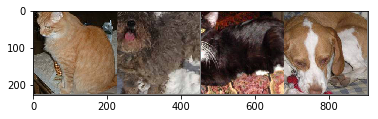

In [8]:
X_train, y_train = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [9]:
model = models.vgg16(pretrained=True)

In [10]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [12]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        parma.requires_grad = True
    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [13]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [14]:
n_epochs = 1
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch{}/{}".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "val"]:
        if param == "train":
            model.train = True
        else:
            model.train = False

        running_loss = 0.0
        running_correct = 0 
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X, y = data
            if use_gpu:
                X, y  = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
        
            optimizer.zero_grad()
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
        
            loss = cost(y_pred, y)
            if param =="train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data[0]
            running_correct += torch.sum(pred == y.data)
            if batch%500 == 0 and param =="train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                      batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
            
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])

        print("{}  Loss:{:.4f},  Correct{:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since   
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch0/1
----------
Batch 500, Train Loss:0.6203, Train ACC:88.9500
Batch 1000, Train Loss:0.5328, Train ACC:90.8000
Batch 1500, Train Loss:0.5420, Train ACC:91.2333
Batch 2000, Train Loss:0.5262, Train ACC:91.8500
Batch 2500, Train Loss:0.5058, Train ACC:92.4400
Batch 3000, Train Loss:0.5251, Train ACC:92.5167
Batch 3500, Train Loss:0.4949, Train ACC:92.7214
Batch 4000, Train Loss:0.5079, Train ACC:93.0000
Batch 4500, Train Loss:0.5064, Train ACC:93.1500
Batch 5000, Train Loss:0.4912, Train ACC:93.3150
Batch 5500, Train Loss:0.4832, Train ACC:93.4136
train  Loss:0.4807,  Correct93.4489
val  Loss:0.2850,  Correct96.2800
Training time is:5m 1s


In [15]:
torch.save(model.state_dict(), "model_vgg16_finetune.pkl")

In [53]:
class ImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, path

In [97]:
data_test_img = ImageFolder(root="./data/",
                                     transform = transform)
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                   batch_size = 1)

In [ ]:
for a,b,c in data_loader_test_img:
    print(a)
    print(b)
    print(c)
    break

In [ ]:
import collections
clip = 0.001
cnt = 1
csv_map = collections.defaultdict(float)

for image, label, path in (data_loader_test_img):
    images = Variable(image.cuda())
    y_pred = model(images)
    _, pred = torch.max(y_pred.data, 1)
    
    
    smax = torch.nn.Softmax()
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob

    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
    prob = np.clip(prob, clip, 1-clip)
    csv_map[path] += prob


In [ ]:
import csv
with open('result' + '.csv', 'w') as csvfile:
    fieldnames = ['id', 'label']
    csv_w = csv.writer(csvfile)
    csv_w.writerow(('id', 'label'))
    for row in sorted(csv_map.items()):
        csv_w.writerow(row)
print("Done.")

Pred Label: ['dog']


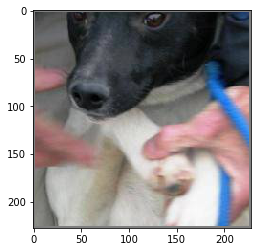

In [91]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = img*std+mean
print("Pred Label:",[classes[i] for i in pred])
plt.imshow(img)